✅ Libraries imported successfully!
✅ Loaded 500 records
✅ Loaded baseline model: Linear Regression
   Baseline R² Score: 1.0000

🔧 Engineering features...
   ✅ Encoded customer name: 498 categories
   ✅ Encoded customer e-mail: 500 categories
   ✅ Encoded country: 211 categories

📏 Scaling features...

✅ Data prepared for advanced analysis
   Training samples: 400
   Test samples: 100
   Features: 8

🚀 STARTING HYPERPARAMETER TUNING

🎲 RANDOMIZED SEARCH - XGBOOST

📊 Parameter Distributions:
   n_estimators: 5 options
   max_depth: 7 options
   learning_rate: 6 options
   subsample: 5 options
   colsample_bytree: 5 options
   min_child_weight: 5 options
   gamma: 6 options

⏳ Starting Randomized Search...
   Iterations: 30
   CV Folds: 3
Fitting 3 folds for each of 30 candidates, totalling 90 fits

✅ Randomized Search Complete!
   Time Elapsed: 10.71 seconds

🏆 Best Parameters:
   subsample: 0.6
   n_estimators: 150
   min_child_weight: 5
   max_depth: 3
   learning_rate: 0.15
   gamma:

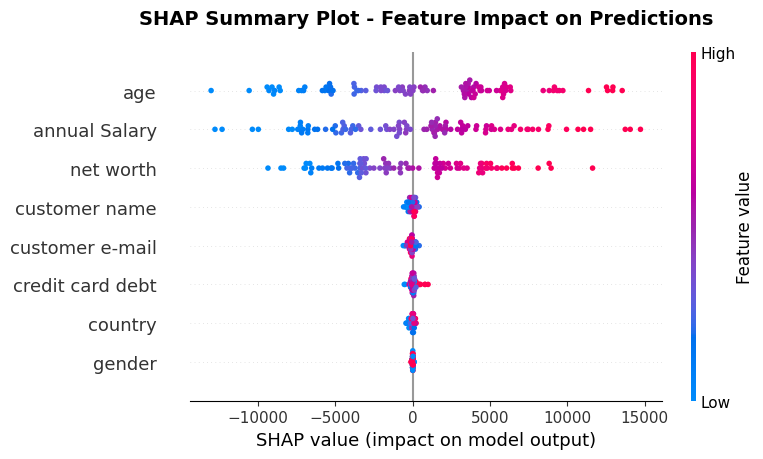


📊 Creating SHAP Feature Importance Plot...
   ✅ Saved to: ..\visualizations\shap\shap_importance.png


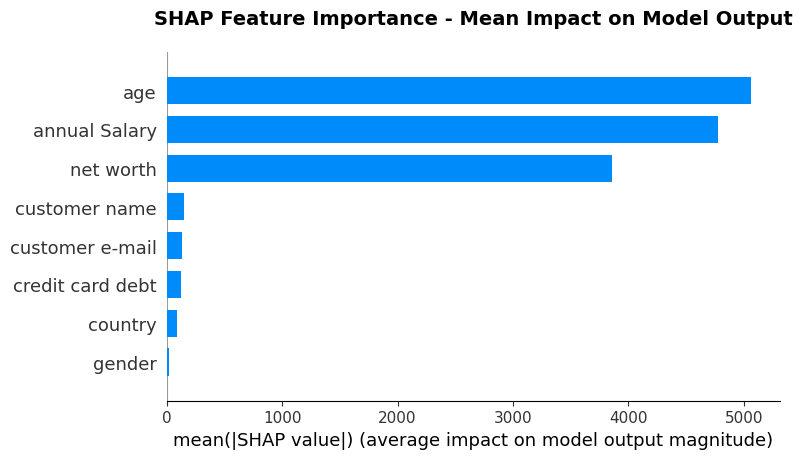


📊 Creating SHAP Waterfall Plot for instance 0...
   ✅ Saved to: ..\visualizations\shap\shap_waterfall.png


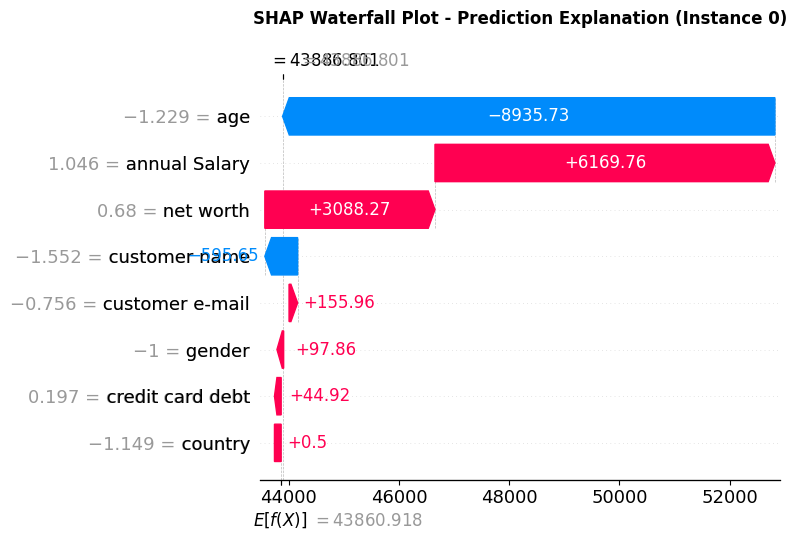


📊 Creating SHAP Dependence Plot for 'age'...
   ✅ Saved to: ..\visualizations\shap\shap_dependence_age.png


<Figure size 1000x600 with 0 Axes>

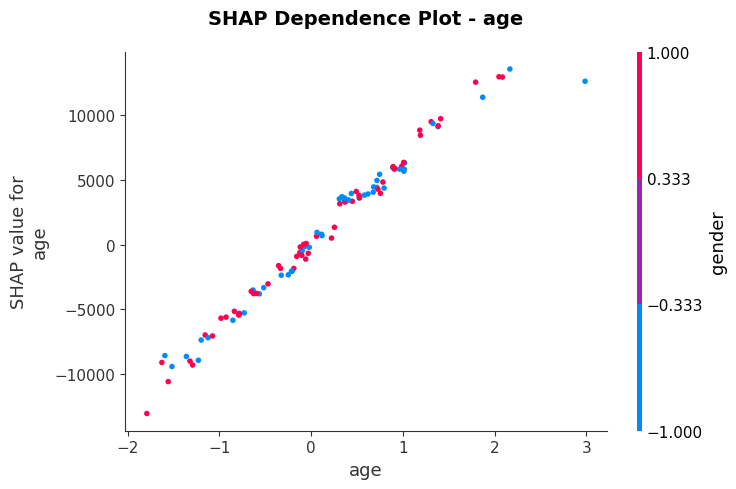


📊 Creating SHAP Dependence Plot for 'annual Salary'...
   ✅ Saved to: ..\visualizations\shap\shap_dependence_annual_Salary.png


<Figure size 1000x600 with 0 Axes>

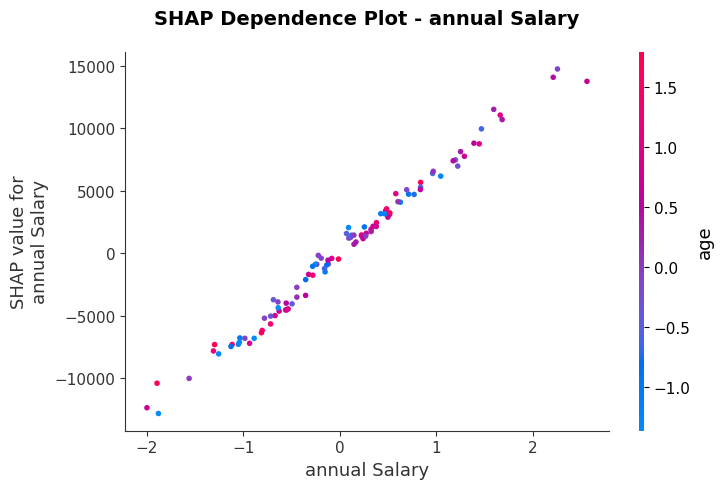


📊 Creating SHAP Dependence Plot for 'net worth'...
   ✅ Saved to: ..\visualizations\shap\shap_dependence_net_worth.png


<Figure size 1000x600 with 0 Axes>

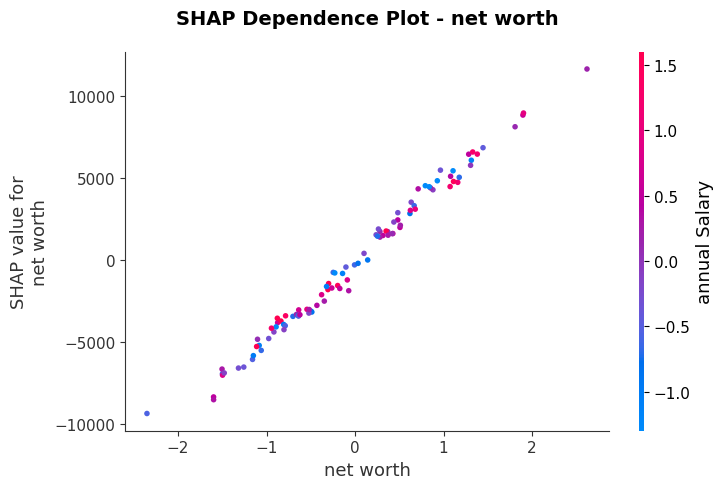


✅ Complete SHAP report generated in: ../visualizations/shap

✅ SHAP analysis complete!

📊 FINAL PERFORMANCE SUMMARY

           Model  R² Score        RMSE         MAE
Baseline XGBoost  1.000000    1.471985    1.164791
   Tuned XGBoost  0.975461 1627.758432 1097.649942

🎯 Performance Improvement: -2.45%

✅ Advanced features implementation complete!


In [1]:
# ===== CELL 1: Setup =====
import pandas as pd
import numpy as np
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../src')
from hyperparameter_tuning import HyperparameterTuner
from model_explainability import ModelExplainer

print("✅ Libraries imported successfully!")

# ===== CELL 2: Load Data and Models =====
import pickle

# Load processed data
df = pd.read_csv('../data/processed/car_sales_clean.csv')
print(f"✅ Loaded {len(df):,} records")

# Load baseline model
with open('../models/best_model.pkl', 'rb') as f:
    baseline_model = pickle.load(f)

with open('../models/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('../models/label_encoders.pkl', 'rb') as f:
    encoders = pickle.load(f)

with open('../models/model_metadata.pkl', 'rb') as f:
    baseline_metadata = pickle.load(f)

print(f"✅ Loaded baseline model: {baseline_metadata['model_name']}")
print(f"   Baseline R² Score: {baseline_metadata['metrics']['test_r2']:.4f}")

# ===== CELL 3: Prepare Data =====
from sklearn.model_selection import train_test_split
from feature_engineering import FeatureEngineer

# Find target column
price_cols = [col for col in df.columns if 'price' in col.lower()]
target_col = price_cols[0] if price_cols else df.columns[-1]

# Feature engineering
engineer = FeatureEngineer()
X, y = engineer.engineer_features(df, target_col)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
X_train_scaled, X_test_scaled = engineer.scale_features(X_train, X_test)

# Convert to DataFrame for SHAP
X_train_scaled = pd.DataFrame(X_train_scaled, columns=engineer.feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=engineer.feature_names)

print(f"\n✅ Data prepared for advanced analysis")
print(f"   Training samples: {len(X_train_scaled):,}")
print(f"   Test samples: {len(X_test_scaled):,}")
print(f"   Features: {len(engineer.feature_names)}")

# ===== CELL 4: Hyperparameter Tuning - XGBoost =====
print("\n" + "="*70)
print("🚀 STARTING HYPERPARAMETER TUNING")
print("="*70)

# Initialize tuner
tuner = HyperparameterTuner(model_type='xgboost')

# Perform Randomized Search (faster than Grid Search)
best_model, best_params = tuner.tune_with_random_search(
    X_train_scaled, 
    y_train, 
    n_iter=30,  # Try 30 different combinations
    cv=3        # 3-fold cross-validation
)

# ===== CELL 5: Evaluate Tuned Model =====
# Evaluate on test set
test_metrics = tuner.evaluate_tuned_model(X_test_scaled, y_test)

# Compare with baseline
tuner.compare_with_baseline(baseline_metadata['metrics']['test_r2'])

# Save tuned model
tuner.save_tuned_model('../models', prefix='tuned_xgboost')

# ===== CELL 6: Update Model Metadata =====
# Create updated metadata
tuned_metadata = {
    'model_name': 'Tuned XGBoost',
    'base_model': baseline_metadata['model_name'],
    'tuning_method': 'RandomizedSearchCV',
    'best_params': best_params,
    'metrics': {
        'test_r2': test_metrics['test_r2'],
        'test_rmse': test_metrics['test_rmse'],
        'test_mae': test_metrics['test_mae'],
        'cv_r2': tuner.best_score
    },
    'baseline_metrics': baseline_metadata['metrics']
}

# Save updated metadata
with open('../models/tuned_model_metadata.pkl', 'wb') as f:
    pickle.dump(tuned_metadata, f)

print("\n✅ Updated model metadata saved!")

# ===== CELL 7: SHAP Explainability =====
print("\n" + "="*70)
print("🔍 STARTING SHAP EXPLAINABILITY ANALYSIS")
print("="*70)

# Initialize explainer with tuned model
explainer = ModelExplainer(
    model=best_model,
    X_train=X_train_scaled,
    feature_names=engineer.feature_names
)

# Calculate SHAP values
shap_values = explainer.calculate_shap_values(X_test_scaled)

# ===== CELL 8: Generate SHAP Visualizations =====
# Generate complete SHAP report
explainer.generate_full_report(
    X_test_scaled,
    output_dir='../visualizations/shap'
)

print("\n✅ SHAP analysis complete!")

# ===== CELL 9: Summary Statistics =====
print("\n" + "="*70)
print("📊 FINAL PERFORMANCE SUMMARY")
print("="*70)

comparison_df = pd.DataFrame({
    'Model': ['Baseline XGBoost', 'Tuned XGBoost'],
    'R² Score': [
        baseline_metadata['metrics']['test_r2'],
        test_metrics['test_r2']
    ],
    'RMSE': [
        baseline_metadata['metrics']['test_rmse'],
        test_metrics['test_rmse']
    ],
    'MAE': [
        baseline_metadata['metrics']['test_mae'],
        test_metrics['test_mae']
    ]
})

print("\n" + comparison_df.to_string(index=False))

improvement = ((test_metrics['test_r2'] - baseline_metadata['metrics']['test_r2']) / 
               baseline_metadata['metrics']['test_r2']) * 100

print(f"\n🎯 Performance Improvement: {improvement:+.2f}%")
print("\n✅ Advanced features implementation complete!")